In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
import numpy as np
import os
import cv2
from glob import glob
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from IPython.display import Image

In [2]:
from itertools import cycle
#from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
#from tensorflow.keras.metrics import auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000005)

In [4]:
train_path = 'D:/MScCS/thesis/Dataset/new/train'
valid_path = 'D:/MScCS/thesis/Dataset/new/test'

In [5]:
# Import the VGG16 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

mobilenet_v2 = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [6]:
# don't train existing weights
for layer in mobilenet_v2.layers:
    layer.trainable = False

In [7]:
# useful for getting number of output classes
folders = glob('D:/MScCS/thesis/Dataset/new/train/*')

In [8]:
#layers
x = Flatten()(mobilenet_v2.output)

In [9]:
# x = Dense(1000, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=mobilenet_v2.input, outputs=prediction)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [11]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=optimizer,
  metrics=['accuracy']
)

In [12]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range= 45,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [13]:
training_set = train_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new/train',
                                                 target_size = (224, 224),
                                                 batch_size = 8,
                                                 class_mode = 'categorical')

Found 800 images belonging to 4 classes.


In [14]:
test_set = test_datagen.flow_from_directory('D:/MScCS/thesis/Dataset/new/test',
                                            target_size = (224, 224),
                                            batch_size = 8,
                                            class_mode = 'categorical')

Found 200 images belonging to 4 classes.


In [22]:
itr = test_datagen.flow_from_directory(
'D:/MScCS/thesis/Dataset/new/test',
target_size=(224,224),
batch_size=8,
class_mode='categorical')

#X, y = itr.next()
x_test, y_test = itr.next()

n_classes = 4
lw = 2

Found 200 images belonging to 4 classes.


In [23]:
def plot_roc_curve():
    #roc curve plot

    y_score = model.predict(x_test)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "green"])
    for i, color in zip(range(n_classes), colors):
        if(i == 0):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of cocci (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 1):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of healthy (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 2):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of ncd (area = {1:0.2f})".format(i, roc_auc[i]),
            )
        if(i == 3):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of salmo (area = {1:0.2f})".format(i, roc_auc[i]),
            )
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic to multiclass")
    plt.legend(loc="lower right")
    plt.show()


In [17]:
def plot_loss_acc():
    # plotting the loss
    plt.plot(r.history['loss'], label='train loss')
    plt.plot(r.history['val_loss'], label='val loss')
    plt.legend()
    plt.ylim(-0.05, 1.1)
    plt.show()

    # plotting the accuracy
    plt.plot(r.history['accuracy'], label='train accuracy')
    plt.plot(r.history['val_accuracy'], label='val accuracy')
    plt.legend()
    plt.ylim(-0.05, 1.1)
    plt.show()

In [29]:
#0.00001
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
100/100 [==============================] - 48s 456ms/step - loss: 1.3993 - accuracy: 0.4675 - val_loss: 0.7515 - val_accuracy: 0.7000
Epoch 2/10
100/100 [==============================] - 39s 389ms/step - loss: 0.6891 - accuracy: 0.7387 - val_loss: 0.4713 - val_accuracy: 0.8250
Epoch 3/10
100/100 [==============================] - 50s 505ms/step - loss: 0.4471 - accuracy: 0.8375 - val_loss: 0.3743 - val_accuracy: 0.8850
Epoch 4/10
100/100 [==============================] - 42s 420ms/step - loss: 0.4183 - accuracy: 0.8425 - val_loss: 0.3261 - val_accuracy: 0.8950
Epoch 5/10
100/100 [==============================] - 39s 386ms/step - loss: 0.3228 - accuracy: 0.8800 - val_loss: 0.2713 - val_accuracy: 0.9000
Epoch 6/10
100/100 [==============================] - 39s 389ms/step - loss: 0.2746 - accuracy: 0.9150 - val_loss: 0.2466 - val_accuracy: 0.9050
Epoch 7/10
100/100 [==============================] - 37s 375ms/step - loss: 0.2024 - accuracy: 0.9225 - val_loss: 0.2203 - val_ac

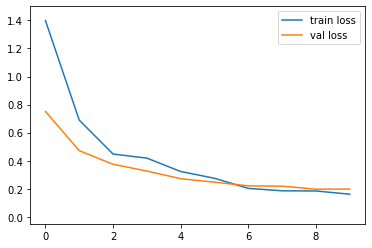

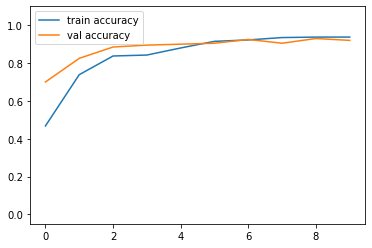

In [31]:
# plotting the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.ylim(-0.05, 1.5)
plt.show()

    # plotting the accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.ylim(-0.05, 1.1)
plt.show()

1/1 [==============================] - 0s 28ms/step


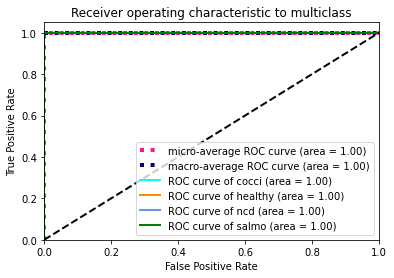

In [42]:
plot_roc_curve()

In [43]:
model.save('./models/mobilenetv2_10.h5')

In [18]:
#0.000005
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/10
100/100 [==============================] - 57s 467ms/step - loss: 1.6103 - accuracy: 0.3975 - val_loss: 1.1926 - val_accuracy: 0.5150
Epoch 2/10
100/100 [==============================] - 46s 459ms/step - loss: 0.9550 - accuracy: 0.6325 - val_loss: 0.7808 - val_accuracy: 0.7250
Epoch 3/10
100/100 [==============================] - 44s 442ms/step - loss: 0.6415 - accuracy: 0.7525 - val_loss: 0.6171 - val_accuracy: 0.7850
Epoch 4/10
100/100 [==============================] - 45s 447ms/step - loss: 0.5772 - accuracy: 0.7912 - val_loss: 0.5164 - val_accuracy: 0.8200
Epoch 5/10
100/100 [==============================] - 42s 421ms/step - loss: 0.4207 - accuracy: 0.8350 - val_loss: 0.4561 - val_accuracy: 0.8650
Epoch 6/10
100/100 [==============================] - 44s 444ms/step - loss: 0.3589 - accuracy: 0.8587 - val_loss: 0.4281 - val_accuracy: 0.8450
Epoch 7/10
100/100 [==============================] - 44s 439ms/step - loss: 0.3433 - accuracy: 0.8838 - val_loss: 0.3850 - val_ac

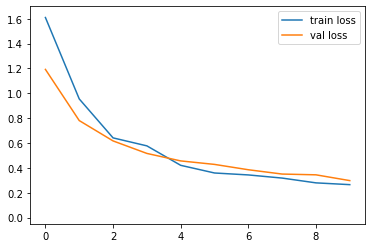

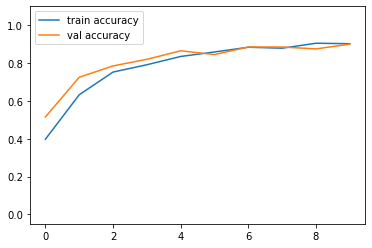

In [19]:
# plotting the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.ylim(-0.05, 1.7)
plt.show()

    # plotting the accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.ylim(-0.05, 1.1)
plt.show()

1/1 [==============================] - 0s 36ms/step


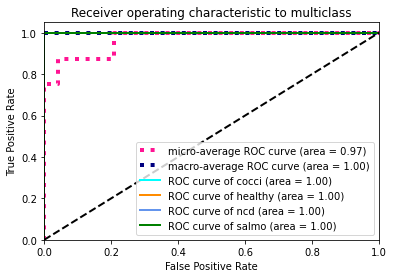

In [24]:
plot_roc_curve()

In [25]:
model.save('./models/mobilenetv25_10.h5')

In [26]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=15,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/15
100/100 [==============================] - 45s 444ms/step - loss: 0.2295 - accuracy: 0.9175 - val_loss: 0.2853 - val_accuracy: 0.8900
Epoch 2/15
100/100 [==============================] - 43s 435ms/step - loss: 0.2125 - accuracy: 0.9337 - val_loss: 0.2735 - val_accuracy: 0.8950
Epoch 3/15
100/100 [==============================] - 44s 436ms/step - loss: 0.1962 - accuracy: 0.9337 - val_loss: 0.2774 - val_accuracy: 0.8900
Epoch 4/15
100/100 [==============================] - 44s 440ms/step - loss: 0.1980 - accuracy: 0.9262 - val_loss: 0.2658 - val_accuracy: 0.8950
Epoch 5/15
100/100 [==============================] - 43s 435ms/step - loss: 0.1927 - accuracy: 0.9362 - val_loss: 0.2452 - val_accuracy: 0.9050
Epoch 6/15
100/100 [==============================] - 44s 439ms/step - loss: 0.1777 - accuracy: 0.9300 - val_loss: 0.2369 - val_accuracy: 0.9050
Epoch 7/15
100/100 [==============================] - 43s 427ms/step - loss: 0.1635 - accuracy: 0.9425 - val_loss: 0.2251 - val_ac

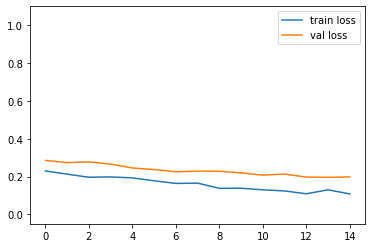

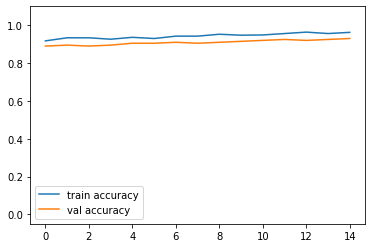

1/1 [==============================] - 0s 31ms/step


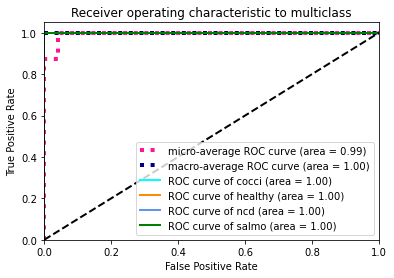

In [28]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_15.h5')

In [29]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
100/100 [==============================] - 40s 403ms/step - loss: 0.0929 - accuracy: 0.9737 - val_loss: 0.1902 - val_accuracy: 0.9250
Epoch 2/20
100/100 [==============================] - 39s 391ms/step - loss: 0.1047 - accuracy: 0.9663 - val_loss: 0.1949 - val_accuracy: 0.9300
Epoch 3/20
100/100 [==============================] - 40s 400ms/step - loss: 0.0988 - accuracy: 0.9775 - val_loss: 0.1927 - val_accuracy: 0.9300
Epoch 4/20
100/100 [==============================] - 39s 393ms/step - loss: 0.0873 - accuracy: 0.9725 - val_loss: 0.1794 - val_accuracy: 0.9350
Epoch 5/20
100/100 [==============================] - 40s 398ms/step - loss: 0.0879 - accuracy: 0.9712 - val_loss: 0.1867 - val_accuracy: 0.9300
Epoch 6/20
100/100 [==============================] - 40s 398ms/step - loss: 0.0835 - accuracy: 0.9725 - val_loss: 0.1804 - val_accuracy: 0.9400
Epoch 7/20
100/100 [==============================] - 40s 400ms/step - loss: 0.0863 - accuracy: 0.9750 - val_loss: 0.1785 - val_ac

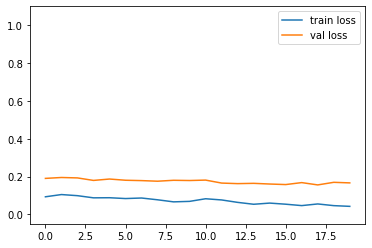

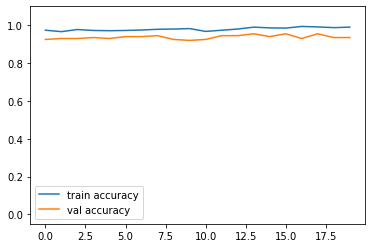

1/1 [==============================] - 0s 32ms/step


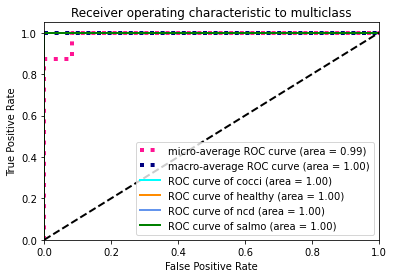

In [30]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_20.h5')

In [31]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=25,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/25
100/100 [==============================] - 49s 484ms/step - loss: 0.0467 - accuracy: 0.9912 - val_loss: 0.1525 - val_accuracy: 0.9350
Epoch 2/25
100/100 [==============================] - 41s 408ms/step - loss: 0.0523 - accuracy: 0.9850 - val_loss: 0.1784 - val_accuracy: 0.9250
Epoch 3/25
100/100 [==============================] - 39s 394ms/step - loss: 0.0407 - accuracy: 0.9887 - val_loss: 0.1621 - val_accuracy: 0.9450
Epoch 4/25
100/100 [==============================] - 41s 414ms/step - loss: 0.0399 - accuracy: 0.9900 - val_loss: 0.1613 - val_accuracy: 0.9400
Epoch 5/25
100/100 [==============================] - 41s 415ms/step - loss: 0.0468 - accuracy: 0.9862 - val_loss: 0.1563 - val_accuracy: 0.9500
Epoch 6/25
100/100 [==============================] - 40s 396ms/step - loss: 0.0451 - accuracy: 0.9862 - val_loss: 0.1491 - val_accuracy: 0.9550
Epoch 7/25
100/100 [==============================] - 40s 398ms/step - loss: 0.0410 - accuracy: 0.9875 - val_loss: 0.1524 - val_ac

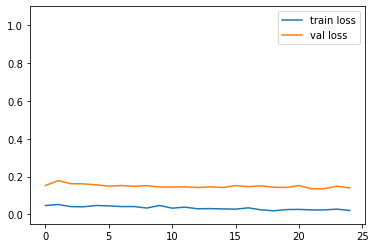

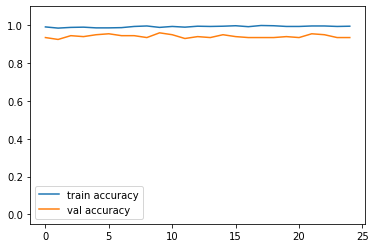

1/1 [==============================] - 0s 55ms/step


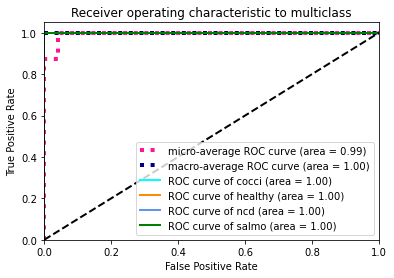

In [32]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_25.h5')

In [33]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=30,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/30
100/100 [==============================] - 40s 399ms/step - loss: 0.0247 - accuracy: 0.9975 - val_loss: 0.1305 - val_accuracy: 0.9500
Epoch 2/30
100/100 [==============================] - 39s 388ms/step - loss: 0.0221 - accuracy: 0.9962 - val_loss: 0.1341 - val_accuracy: 0.9400
Epoch 3/30
100/100 [==============================] - 42s 416ms/step - loss: 0.0270 - accuracy: 0.9962 - val_loss: 0.1329 - val_accuracy: 0.9400
Epoch 4/30
100/100 [==============================] - 39s 394ms/step - loss: 0.0193 - accuracy: 0.9975 - val_loss: 0.1495 - val_accuracy: 0.9350
Epoch 5/30
100/100 [==============================] - 40s 395ms/step - loss: 0.0185 - accuracy: 0.9975 - val_loss: 0.1368 - val_accuracy: 0.9450
Epoch 6/30
100/100 [==============================] - 41s 407ms/step - loss: 0.0186 - accuracy: 0.9975 - val_loss: 0.1358 - val_accuracy: 0.9400
Epoch 7/30
100/100 [==============================] - 39s 389ms/step - loss: 0.0167 - accuracy: 0.9987 - val_loss: 0.1434 - val_ac

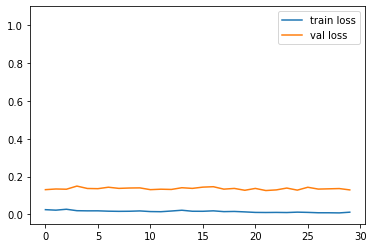

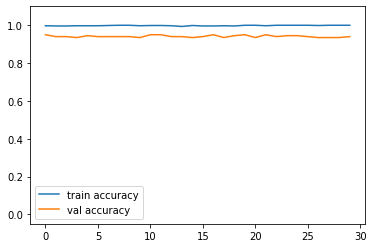

1/1 [==============================] - 0s 34ms/step


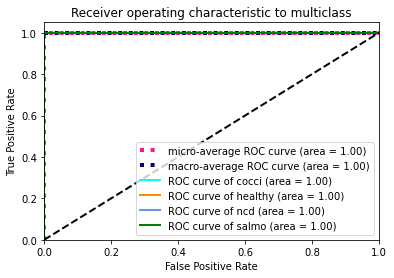

In [34]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_30.h5')

In [35]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=35,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/35
100/100 [==============================] - 38s 383ms/step - loss: 0.0121 - accuracy: 0.9987 - val_loss: 0.1351 - val_accuracy: 0.9350
Epoch 2/35
100/100 [==============================] - 37s 374ms/step - loss: 0.0110 - accuracy: 0.9987 - val_loss: 0.1370 - val_accuracy: 0.9450
Epoch 3/35
100/100 [==============================] - 39s 394ms/step - loss: 0.0093 - accuracy: 0.9987 - val_loss: 0.1313 - val_accuracy: 0.9400
Epoch 4/35
100/100 [==============================] - 40s 403ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.1259 - val_accuracy: 0.9450
Epoch 5/35
100/100 [==============================] - 42s 425ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1390 - val_accuracy: 0.9350
Epoch 6/35
100/100 [==============================] - 46s 460ms/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.1304 - val_accuracy: 0.9450
Epoch 7/35
100/100 [==============================] - 103s 1s/step - loss: 0.0076 - accuracy: 1.0000 - val_loss: 0.1417 - val_accu

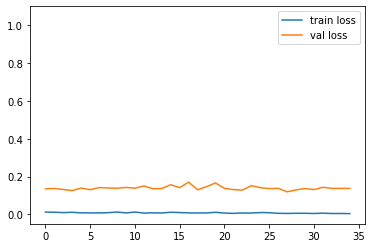

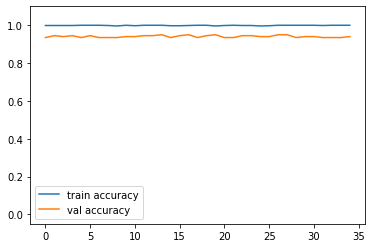

1/1 [==============================] - 0s 55ms/step


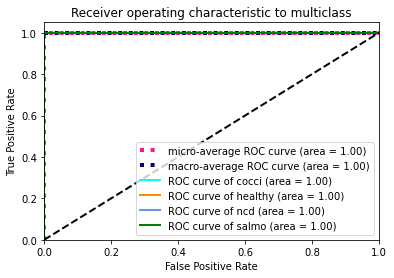

In [36]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_35.h5')

In [43]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=40,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/40
100/100 [==============================] - 41s 411ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.1463 - val_accuracy: 0.9500
Epoch 2/40
100/100 [==============================] - 39s 392ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.1470 - val_accuracy: 0.9450
Epoch 3/40
100/100 [==============================] - 39s 390ms/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.1306 - val_accuracy: 0.9400
Epoch 4/40
100/100 [==============================] - 39s 387ms/step - loss: 0.0058 - accuracy: 0.9987 - val_loss: 0.1382 - val_accuracy: 0.9400
Epoch 5/40
100/100 [==============================] - 38s 385ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.1382 - val_accuracy: 0.9450
Epoch 6/40
100/100 [==============================] - 39s 387ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.1358 - val_accuracy: 0.9450
Epoch 7/40
100/100 [==============================] - 39s 392ms/step - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.1523 - val_ac

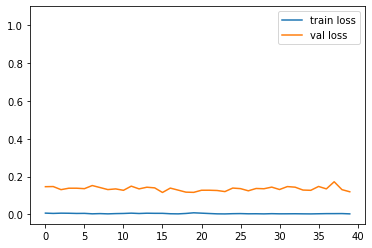

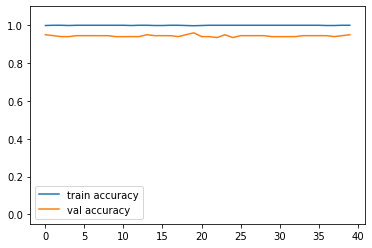

In [44]:
plot_loss_acc()

1/1 [==============================] - 0s 37ms/step


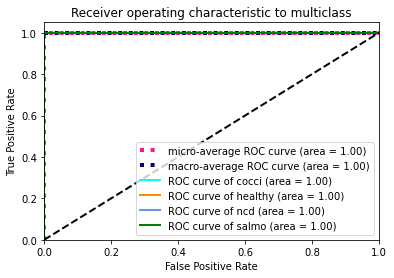

In [45]:
plot_roc_curve()
model.save('./models/mobilenetv2_40.h5')

In [50]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=45,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/45
100/100 [==============================] - 41s 406ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1223 - val_accuracy: 0.9500
Epoch 2/45
100/100 [==============================] - 38s 386ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.1327 - val_accuracy: 0.9600
Epoch 3/45
100/100 [==============================] - 38s 380ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1206 - val_accuracy: 0.9500
Epoch 4/45
100/100 [==============================] - 38s 379ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.1197 - val_accuracy: 0.9500
Epoch 5/45
100/100 [==============================] - 38s 378ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.1452 - val_accuracy: 0.9450
Epoch 6/45
100/100 [==============================] - 38s 379ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.1427 - val_accuracy: 0.9400
Epoch 7/45
100/100 [==============================] - 38s 376ms/step - loss: 0.0040 - accuracy: 0.9975 - val_loss: 0.1210 - val_ac

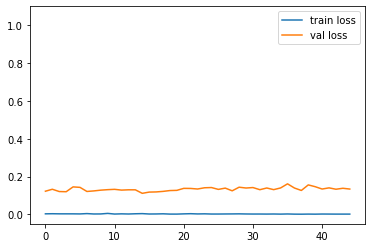

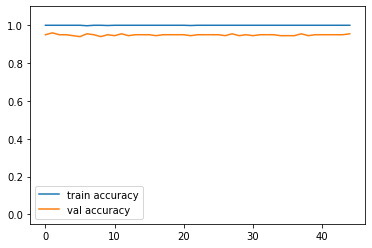

In [51]:
plot_loss_acc()

1/1 [==============================] - 0s 32ms/step


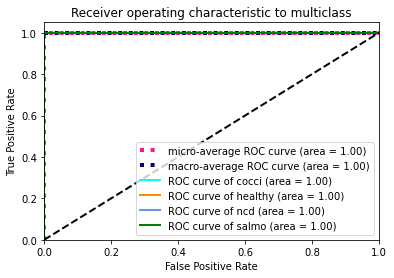

In [52]:
plot_roc_curve()
model.save('./models/mobilenetv2_45.h5')

In [53]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
100/100 [==============================] - 38s 384ms/step - loss: 0.0026 - accuracy: 0.9987 - val_loss: 0.1537 - val_accuracy: 0.9500
Epoch 2/50
100/100 [==============================] - 38s 381ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.1167 - val_accuracy: 0.9550
Epoch 3/50
100/100 [==============================] - 38s 376ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1423 - val_accuracy: 0.9500
Epoch 4/50
100/100 [==============================] - 38s 378ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.1239 - val_accuracy: 0.9500
Epoch 5/50
100/100 [==============================] - 38s 380ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1184 - val_accuracy: 0.9550
Epoch 6/50
100/100 [==============================] - 38s 382ms/step - loss: 8.8370e-04 - accuracy: 1.0000 - val_loss: 0.1256 - val_accuracy: 0.9550
Epoch 7/50
100/100 [==============================] - 39s 394ms/step - loss: 8.1549e-04 - accuracy: 1.0000 - val_loss: 0.1333 

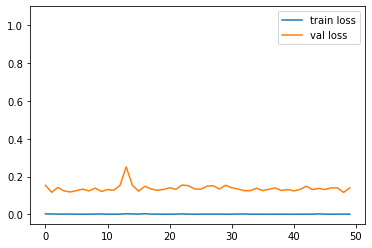

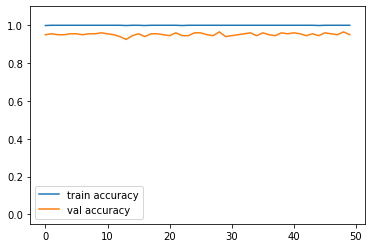

In [54]:
plot_loss_acc()

1/1 [==============================] - 0s 30ms/step


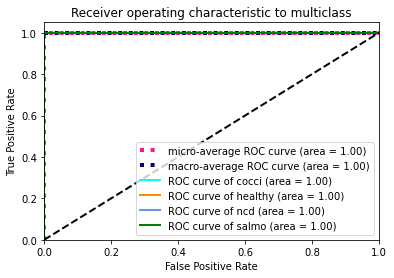

In [55]:
plot_roc_curve()
model.save('./models/mobilenetv2_50.h5')

In [56]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=60,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/60
100/100 [==============================] - 39s 385ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1280 - val_accuracy: 0.9550
Epoch 2/60
100/100 [==============================] - 38s 378ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1288 - val_accuracy: 0.9550
Epoch 3/60
100/100 [==============================] - 38s 381ms/step - loss: 3.6211e-04 - accuracy: 1.0000 - val_loss: 0.1274 - val_accuracy: 0.9550
Epoch 4/60
100/100 [==============================] - 38s 381ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.1339 - val_accuracy: 0.9550
Epoch 5/60
100/100 [==============================] - 38s 379ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1385 - val_accuracy: 0.9500
Epoch 6/60
100/100 [==============================] - 38s 380ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1424 - val_accuracy: 0.9500
Epoch 7/60
100/100 [==============================] - 38s 381ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1238 - va

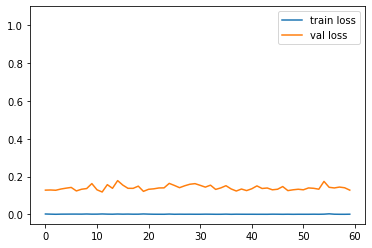

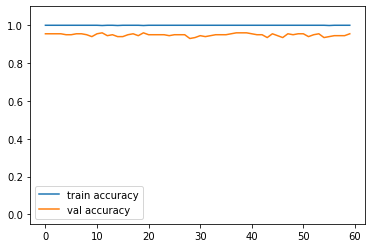

1/1 [==============================] - 0s 34ms/step


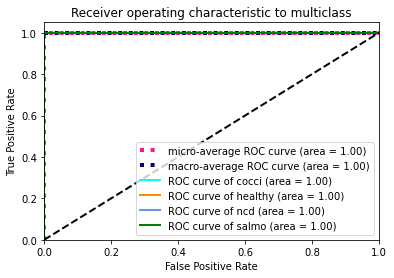

In [57]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_60.h5')

In [58]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=70,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/70
100/100 [==============================] - 40s 400ms/step - loss: 5.7524e-04 - accuracy: 1.0000 - val_loss: 0.1401 - val_accuracy: 0.9550
Epoch 2/70
100/100 [==============================] - 38s 381ms/step - loss: 3.8342e-04 - accuracy: 1.0000 - val_loss: 0.1390 - val_accuracy: 0.9500
Epoch 3/70
100/100 [==============================] - 38s 377ms/step - loss: 5.0169e-04 - accuracy: 1.0000 - val_loss: 0.1280 - val_accuracy: 0.9550
Epoch 4/70
100/100 [==============================] - 38s 379ms/step - loss: 2.9888e-04 - accuracy: 1.0000 - val_loss: 0.1212 - val_accuracy: 0.9600
Epoch 5/70
100/100 [==============================] - 38s 378ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.1124 - val_accuracy: 0.9600
Epoch 6/70
100/100 [==============================] - 38s 377ms/step - loss: 0.0018 - accuracy: 0.9987 - val_loss: 0.1448 - val_accuracy: 0.9450
Epoch 7/70
100/100 [==============================] - 38s 377ms/step - loss: 4.9194e-04 - accuracy: 1.0000 - val_l

Epoch 56/70
100/100 [==============================] - 37s 375ms/step - loss: 2.7561e-04 - accuracy: 1.0000 - val_loss: 0.1534 - val_accuracy: 0.9350
Epoch 57/70
100/100 [==============================] - 37s 374ms/step - loss: 2.7851e-04 - accuracy: 1.0000 - val_loss: 0.1579 - val_accuracy: 0.9450
Epoch 58/70
100/100 [==============================] - 37s 374ms/step - loss: 3.5174e-04 - accuracy: 1.0000 - val_loss: 0.1294 - val_accuracy: 0.9550
Epoch 59/70
100/100 [==============================] - 38s 377ms/step - loss: 2.8358e-04 - accuracy: 1.0000 - val_loss: 0.1544 - val_accuracy: 0.9500
Epoch 60/70
100/100 [==============================] - 38s 377ms/step - loss: 3.8961e-04 - accuracy: 1.0000 - val_loss: 0.1442 - val_accuracy: 0.9550
Epoch 61/70
100/100 [==============================] - 38s 378ms/step - loss: 2.7419e-04 - accuracy: 1.0000 - val_loss: 0.1320 - val_accuracy: 0.9500
Epoch 62/70
100/100 [==============================] - 38s 376ms/step - loss: 1.9227e-04 - accuracy:

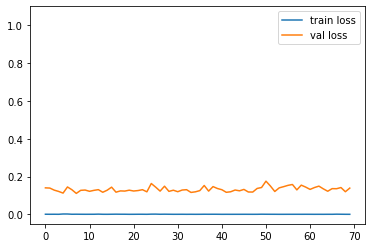

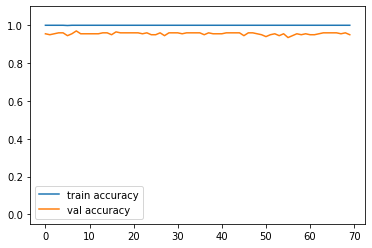

1/1 [==============================] - 0s 31ms/step


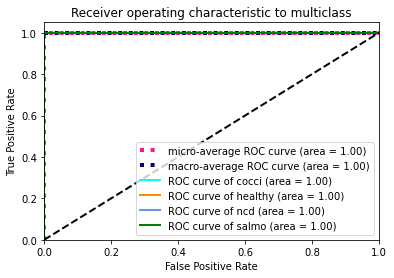

In [59]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_70.h5')

In [60]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=80,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/80
100/100 [==============================] - 38s 383ms/step - loss: 4.4926e-04 - accuracy: 1.0000 - val_loss: 0.1281 - val_accuracy: 0.9600
Epoch 2/80
100/100 [==============================] - 38s 379ms/step - loss: 1.5573e-04 - accuracy: 1.0000 - val_loss: 0.1250 - val_accuracy: 0.9550
Epoch 3/80
100/100 [==============================] - 38s 379ms/step - loss: 3.0069e-04 - accuracy: 1.0000 - val_loss: 0.1285 - val_accuracy: 0.9600
Epoch 4/80
100/100 [==============================] - 38s 381ms/step - loss: 2.7484e-04 - accuracy: 1.0000 - val_loss: 0.1406 - val_accuracy: 0.9550
Epoch 5/80
100/100 [==============================] - 38s 380ms/step - loss: 2.8108e-04 - accuracy: 1.0000 - val_loss: 0.1251 - val_accuracy: 0.9600
Epoch 6/80
100/100 [==============================] - 38s 380ms/step - loss: 2.6530e-04 - accuracy: 1.0000 - val_loss: 0.1483 - val_accuracy: 0.9550
Epoch 7/80
100/100 [==============================] - 38s 380ms/step - loss: 1.4426e-04 - accuracy: 1.0000

Epoch 56/80
100/100 [==============================] - 40s 397ms/step - loss: 1.5004e-04 - accuracy: 1.0000 - val_loss: 0.1416 - val_accuracy: 0.9600
Epoch 57/80
100/100 [==============================] - 38s 383ms/step - loss: 1.8644e-04 - accuracy: 1.0000 - val_loss: 0.1460 - val_accuracy: 0.9550
Epoch 58/80
100/100 [==============================] - 38s 379ms/step - loss: 1.3575e-04 - accuracy: 1.0000 - val_loss: 0.1483 - val_accuracy: 0.9550
Epoch 59/80
100/100 [==============================] - 38s 380ms/step - loss: 1.4053e-04 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.9550
Epoch 60/80
100/100 [==============================] - 38s 382ms/step - loss: 8.5427e-05 - accuracy: 1.0000 - val_loss: 0.1414 - val_accuracy: 0.9600
Epoch 61/80
100/100 [==============================] - 38s 380ms/step - loss: 2.8543e-04 - accuracy: 1.0000 - val_loss: 0.1132 - val_accuracy: 0.9650
Epoch 62/80
100/100 [==============================] - 38s 382ms/step - loss: 0.0014 - accuracy: 0.9

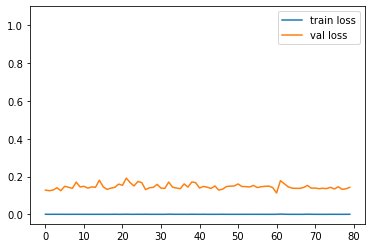

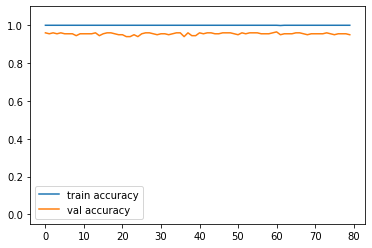

1/1 [==============================] - 0s 31ms/step


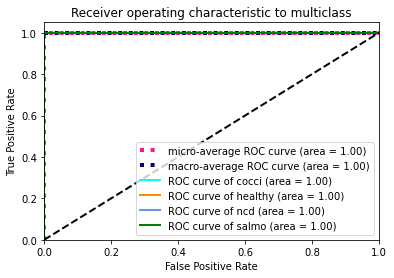

In [61]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_80.h5')

In [62]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=90,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/90
100/100 [==============================] - 38s 383ms/step - loss: 2.2534e-04 - accuracy: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.9500
Epoch 2/90
100/100 [==============================] - 38s 376ms/step - loss: 4.2465e-04 - accuracy: 1.0000 - val_loss: 0.1282 - val_accuracy: 0.9550
Epoch 3/90
100/100 [==============================] - 38s 379ms/step - loss: 2.8499e-04 - accuracy: 1.0000 - val_loss: 0.1186 - val_accuracy: 0.9600
Epoch 4/90
100/100 [==============================] - 38s 377ms/step - loss: 1.7429e-04 - accuracy: 1.0000 - val_loss: 0.1311 - val_accuracy: 0.9550
Epoch 5/90
100/100 [==============================] - 38s 377ms/step - loss: 2.0132e-04 - accuracy: 1.0000 - val_loss: 0.1267 - val_accuracy: 0.9450
Epoch 6/90
100/100 [==============================] - 38s 380ms/step - loss: 1.1507e-04 - accuracy: 1.0000 - val_loss: 0.1330 - val_accuracy: 0.9500
Epoch 7/90
100/100 [==============================] - 38s 377ms/step - loss: 5.1917e-04 - accuracy: 1.0000

Epoch 56/90
100/100 [==============================] - 41s 413ms/step - loss: 7.7667e-05 - accuracy: 1.0000 - val_loss: 0.1821 - val_accuracy: 0.9400
Epoch 57/90
100/100 [==============================] - 41s 411ms/step - loss: 6.4709e-05 - accuracy: 1.0000 - val_loss: 0.1760 - val_accuracy: 0.9550
Epoch 58/90
100/100 [==============================] - 41s 414ms/step - loss: 7.5580e-05 - accuracy: 1.0000 - val_loss: 0.1720 - val_accuracy: 0.9550
Epoch 59/90
100/100 [==============================] - 42s 424ms/step - loss: 1.2247e-04 - accuracy: 1.0000 - val_loss: 0.1682 - val_accuracy: 0.9600
Epoch 60/90
100/100 [==============================] - 39s 389ms/step - loss: 1.9924e-04 - accuracy: 1.0000 - val_loss: 0.1896 - val_accuracy: 0.9400
Epoch 61/90
100/100 [==============================] - 40s 399ms/step - loss: 1.0981e-04 - accuracy: 1.0000 - val_loss: 0.1680 - val_accuracy: 0.9550
Epoch 62/90
100/100 [==============================] - 40s 401ms/step - loss: 5.3920e-05 - accuracy:

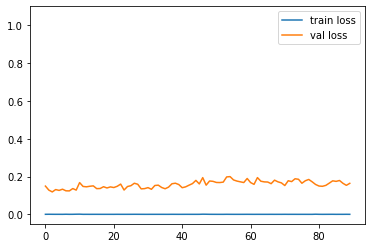

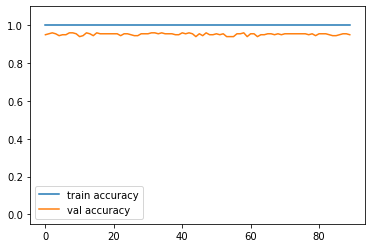

1/1 [==============================] - 0s 34ms/step


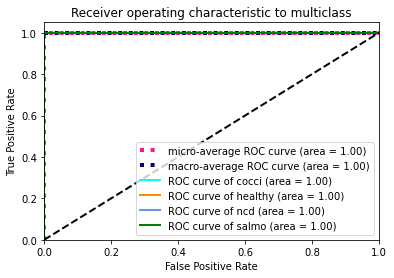

In [63]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_90.h5')

In [64]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=100,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/100
100/100 [==============================] - 39s 393ms/step - loss: 1.2906e-04 - accuracy: 1.0000 - val_loss: 0.1716 - val_accuracy: 0.9500
Epoch 2/100
100/100 [==============================] - 42s 418ms/step - loss: 9.0096e-05 - accuracy: 1.0000 - val_loss: 0.1768 - val_accuracy: 0.9500
Epoch 3/100
100/100 [==============================] - 39s 392ms/step - loss: 4.3796e-05 - accuracy: 1.0000 - val_loss: 0.1724 - val_accuracy: 0.9500
Epoch 4/100
100/100 [==============================] - 39s 395ms/step - loss: 5.1637e-05 - accuracy: 1.0000 - val_loss: 0.1676 - val_accuracy: 0.9500
Epoch 5/100
100/100 [==============================] - 41s 407ms/step - loss: 1.2227e-04 - accuracy: 1.0000 - val_loss: 0.1706 - val_accuracy: 0.9500
Epoch 6/100
100/100 [==============================] - 39s 393ms/step - loss: 5.5471e-05 - accuracy: 1.0000 - val_loss: 0.1659 - val_accuracy: 0.9500
Epoch 7/100
100/100 [==============================] - 41s 408ms/step - loss: 8.1871e-05 - accuracy:

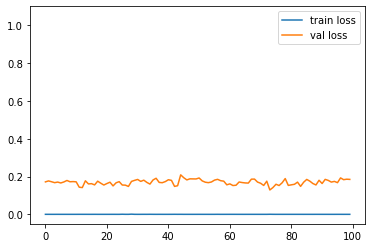

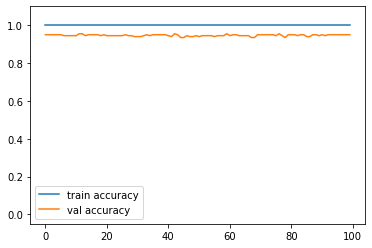

1/1 [==============================] - 0s 39ms/step


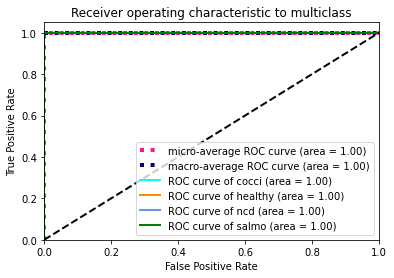

In [65]:
plot_loss_acc()
plot_roc_curve()
model.save('./models/mobilenetv2_100.h5')

In [23]:
path = 'D:/MScCS/thesis/Dataset/new/separate testing/salmo/'
count = 0
for i in os.listdir(path):
    filename = path + i
    Image(filename,width=224,height=224)
    img = image.load_img(filename,target_size=(224, 224))

    resizedimg = image.img_to_array(img)
    finalimg = np.expand_dims(resizedimg,axis=0)
    finalimg = tf.keras.applications.mobilenet_v2.preprocess_input(finalimg)
    finalimg.shape
    predictions = model.predict(finalimg)

    #print(np.argmax(predictions))
    category = np.argmax(predictions)
    if(category == 3):
        count = count + 1
        
print('Total accurate prediction for cocci:', count)

1/1 [==============================] - 0s 19ms/step
Total accurate prediction for cocci: 22


In [67]:
#epoch 15- 69
#epoch 10,20 - 70
#epoch 25 - 72
#epoch 30 - 74
#epoch 40,45 - 76
#epoch 35,50,70,80,90 - 77
#epoch 60 - 78
#epoch 100 - 79


In [ ]:
#epoch 60 - loss: 7.4098e-04 - accuracy: 1.0000 - val_loss: 0.1280 - val_accuracy: 0.9550

In [15]:
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/50
100/100 [==============================] - 45s 357ms/step - loss: 1.5191 - accuracy: 0.4200 - val_loss: 1.0755 - val_accuracy: 0.5700
Epoch 2/50
100/100 [==============================] - 35s 345ms/step - loss: 0.9083 - accuracy: 0.6637 - val_loss: 0.7323 - val_accuracy: 0.7050
Epoch 3/50
100/100 [==============================] - 34s 338ms/step - loss: 0.6875 - accuracy: 0.7437 - val_loss: 0.5873 - val_accuracy: 0.7550
Epoch 4/50
100/100 [==============================] - 36s 356ms/step - loss: 0.5651 - accuracy: 0.7875 - val_loss: 0.4870 - val_accuracy: 0.7850
Epoch 5/50
100/100 [==============================] - 35s 346ms/step - loss: 0.4618 - accuracy: 0.8300 - val_loss: 0.4216 - val_accuracy: 0.8250
Epoch 6/50
100/100 [==============================] - 34s 342ms/step - loss: 0.3853 - accuracy: 0.8587 - val_loss: 0.3853 - val_accuracy: 0.8150
Epoch 7/50
100/100 [==============================] - 35s 349ms/step - loss: 0.3571 - accuracy: 0.8512 - val_loss: 0.3510 - val_ac

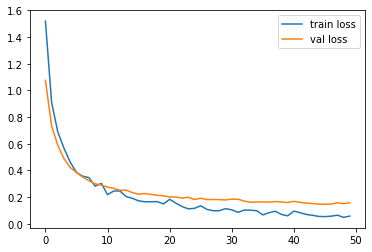

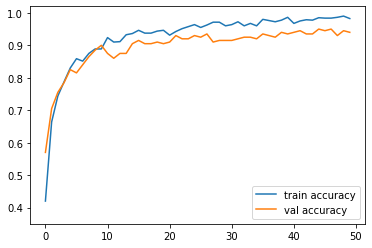

In [19]:
# plotting the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.ylim(-0.03, 1.6)
plt.show()

    # plotting the accuracy
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.ylim(0.35, 1.02)
plt.show()